# Chapter 5 - Resampling Methods

- [Load dataset](#Load-dataset)
- [Cross-Validation](#5.1-Cross-Validation)

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

### Load dataset

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [3]:
df1 = pd.read_csv('data/Auto.csv', na_values='?').dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.0+ KB


#### Cross-Validation

##### Validation Set Approach
Using Polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features

(10, 10) (10, 10)
[ 1  2  3  4  5  6  7  8  9 10]


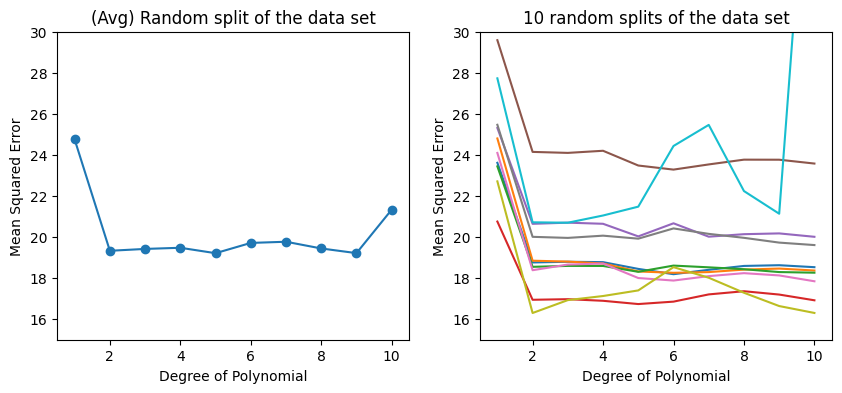

In [23]:
t_prop = 0.5 ## training set is small, which may lead to overfitting when model complexity increases
p_order = np.arange(1,11) #[1, 2,...10]
r_state = np.arange(0,10) # [0, 1, .. 9]

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j])) # input is order
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0],np.mean(Z.T, axis=0), '-o')
ax1.set_title('(Avg) Random split of the data set')

# Right plot (all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

##### LOOCV

In [12]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df1)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df1.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

print(scores)

[-24.231513517929226, -19.248213124489574, -19.33498406408846, -19.424430307307563, -19.03320629071331, -18.970104450960832, -19.125909181604783, -19.2242272557231, -19.13386069241766, -18.946774731780295]


In [29]:
# k-fold CV
folds = 10

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, random_state=Y[i,j], shuffle=True)
    Z[i,j] = cross_val_score(regr, X_poly, df1.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()

print(Z.T[0])   

[-24.20766449 -19.18533142 -19.27626666 -19.47848402 -19.13719673
 -19.05733981 -19.25366325 -19.37919453 -19.24926393 -18.93006452]


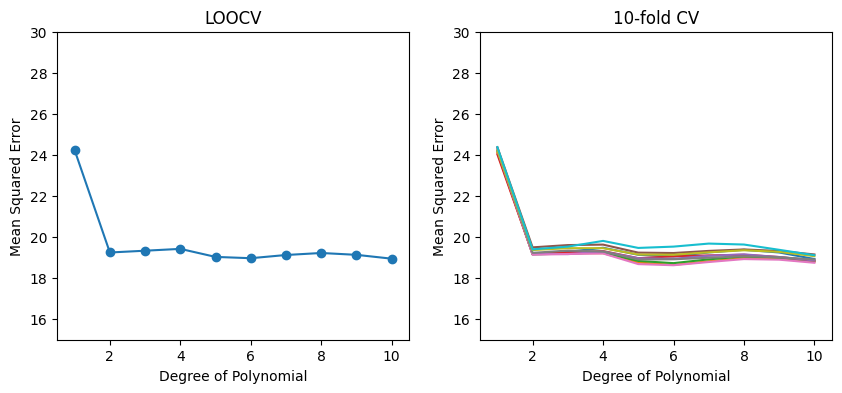

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Note: cross_val_score() method return negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot

ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

##### BootStrap

[ 1  2  3  4  5  6  7  8  9 10]


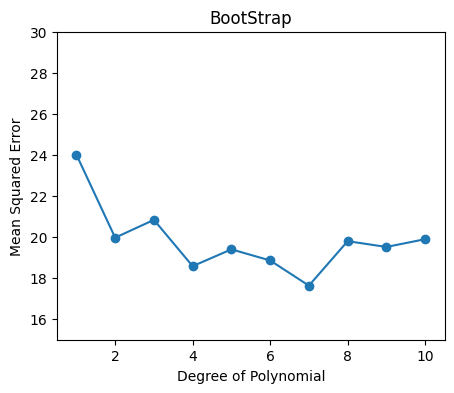

In [44]:
num_boot_iter = 10

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))

    for iter in range(num_boot_iter):

        X_poly_temp, y_temp = resample(X_poly, df1.mpg.values, random_state=Y[i,j]+X[i,j])

        X_train, X_test, y_train, y_test = train_test_split(X_poly_temp, y_temp,
                                                            test_size=0.3, random_state=Y[i,j])
        
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        Z[i,j] += mean_squared_error(y_test, pred)

    Z[i,j] = Z[i,j] / num_boot_iter

    

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
print(X.T[0])
ax.plot(X.T[0], np.mean(Z.T, axis=0), '-o')
ax.set_title('BootStrap')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2))